# Importing the required dependencies

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
torch.manual_seed(1337)

from matplotlib import pyplot as plt

# Device configuration

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print('GPU:', torch.cuda.get_device_properties(0).name)
else:
    print("CPU")

GPU: NVIDIA GeForce GTX 1650 Ti


# Loading dataset

In [3]:
with open("./tinyShakesphere.txt", "r", encoding="utf-8") as file:
    text = file.read()

# Creating Vocabulary

In [4]:
chars = sorted(set(text))
vocab_size = len(chars) 
print(''.join(chars))
print(len(chars))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [5]:
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Encoding Dataset and Train, Test Split

In [6]:
encoded_text = torch.tensor(encode(text), dtype=torch.long)

In [7]:
encoded_text

tensor([18, 47, 56,  ..., 52, 45,  8])

In [8]:
train_size = 0.9

train_data = encoded_text[:int(train_size*len(encoded_text))]
val_data = encoded_text[int(train_size*len(encoded_text)):]

# Modeling

In [9]:
block_size = 8
batch_size = 4
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

In [10]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, device='cpu'):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        self.device = device
    
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx) # (B,T,C) B-> 4(batch_size),T-> 8(block_size),C-> 65(vocab_size)
        if targets is None:
            loss = None
        else: 
            B, T, C =  logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:,-1,:] # (B, C)
            probs = F.softmax(logits, dim=1) # (B, C)
            idx_next = torch.multinomial(probs,num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
 

# Model init and sampling before training 

In [11]:
bigram = BigramLanguageModel(vocab_size).to(device)

In [12]:
print(decode(bigram.generate(torch.tensor([[0]], dtype=torch.long,device=device), max_new_tokens=100)[0].tolist()))


pYCXxfRkRZd
wc'wfNfT;OLlTEeC K
jxqPToTb?bXAUG:C-SGJO-33SM:C?YI3a
hs:LVXJFhXeNuwqhObxZ.tSVrddXlaSZaNe


# Optimizer init and training the model

In [13]:
optimizer = optim.AdamW(bigram.parameters(), lr=1e-3)

In [14]:
@torch.no_grad()
def estimate_loss(model, eval_iters):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x,y = get_batch(split)
            logits, loss = model(x,y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [15]:
train_loss = []
val_loss = []
step = []

In [19]:
batch_size = 32
eval_iters = 100
for steps in range(5000):
    if steps % eval_iters == 0:
        losses = estimate_loss(bigram, eval_iters)
        print(f'step {steps}: train loss {losses['train']:.4f}, test loss {losses['val']:.4f}')
        train_loss.append(losses['train'])
        val_loss.append(losses['val'])
        step.append(step[-1] + eval_iters if step else eval_iters)
    xb, yb = get_batch(train_data)
    logits, loss = bigram(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

step 0: train loss 2.6351, test loss 2.4793
step 100: train loss 2.6360, test loss 2.4731
step 200: train loss 2.6354, test loss 2.4747
step 300: train loss 2.6343, test loss 2.4549
step 400: train loss 2.6199, test loss 2.4820
step 500: train loss 2.6276, test loss 2.4482
step 600: train loss 2.6217, test loss 2.4637
step 700: train loss 2.6187, test loss 2.4554
step 800: train loss 2.6347, test loss 2.4451
step 900: train loss 2.6190, test loss 2.4501
step 1000: train loss 2.6173, test loss 2.4397
step 1100: train loss 2.6143, test loss 2.4441
step 1200: train loss 2.5909, test loss 2.4151
step 1300: train loss 2.6145, test loss 2.4420
step 1400: train loss 2.6009, test loss 2.4267
step 1500: train loss 2.6253, test loss 2.4188
step 1600: train loss 2.5982, test loss 2.4224
step 1700: train loss 2.5989, test loss 2.4177
step 1800: train loss 2.5999, test loss 2.4132
step 1900: train loss 2.6233, test loss 2.4132
step 2000: train loss 2.6022, test loss 2.4130
step 2100: train loss 2.6

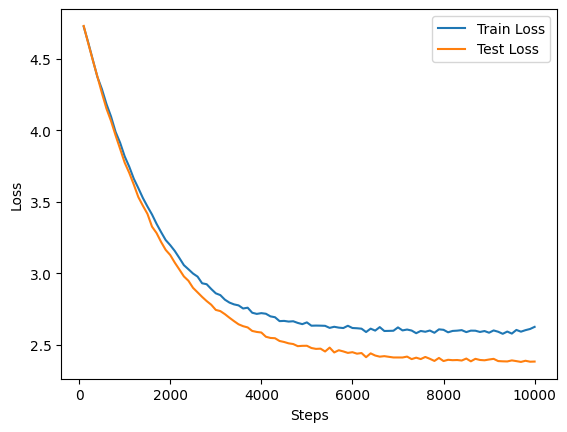

In [20]:
plt.plot(step, train_loss, label='Train Loss')
plt.plot(step, val_loss, label='Test Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Sampling from the trained model

In [21]:
print(decode(bigram.generate(torch.tensor([[0]], dtype=torch.long,device=device), max_new_tokens=1000)[0].tolist()))


O:

STworinggin ie-ve INDEThiWho aste ndichea ber br
Hed hy senInirmy a theint co Kas, the an Pinke imyol menatoulinor, teire biwimapise.


we e wo IOSis;
ST d tho y'silHI whertaperulllalou! trencolirconou jbea d f t wothrmu th?O:
TARUCHIORUCHI it il c; d j.
Whtir Whth'dlll my ay meras be:
Hang o ndonze t t tot nom theabof s ho anga thitan nu tonm THIERTRe y, d.
Pl!
HIO:
Wo, IEThens arr wholers e
Thins; s ookesthouk bl,-der, s, es s;

IO:

TENak!--
STRUCH:
OND.
Thateee wheresed we hrist ar
INCELONSTHIO:
PERO:
PTLONTRUC&fo thin.


'd! Wheseson rishe. ar?
A:
GRO:IA:
Whthathe couf mhir, byoass o'PEMI'thisese hawayol brnd end,
My w flouth sth t ar h ccr:
Wive! t, o amongh,
Poul? tald weat r theat mef fowalo' I o!
Aw'd wer ho'liower lifu he punilf gur ou t theeake; Sk:
Anow.
Whur woury pmouthak nd avenseng,
BISibrtus nce stho, JWhesh pat ing:
Ingio shown'ed.
Whathee ss me ote h henide a anair, I my abukl t,
A:

LIAThy ayceve cotinorir.

SGry, higo m fasstou s, aubis t htereerd
Bir cther d 